# TADBSCAN Stop Detection

The second stop detection algorithm implemented in ```nomad``` is an adaptation of DBSCAN. Unlike in plain DBSCAN, we also incorporate the time dimension to determine if two pings are "neighbors". This implementation relies on 3 parameters

* `time_thresh` defines the maximum time difference (in minutes) between two consecutive pings for them to be considered neighbors within the same cluster.
* `dist_thresh` specifies the maximum spatial distance (in meters) between two pings for them to be considered neighbors.
* `min_pts` sets the minimum number of neighbors required for a ping to form a cluster.

Notice that this method also works with **geographic coordinates** (lon, lat), using Haversine distance. 

In [ ]:
%matplotlib inline

# Imports
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import box
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nomad.stop_detection.viz import plot_stops_barcode, plot_time_barcode
import nomad.stop_detection.dbscan as DBSCAN
import nomad.filters as filters 
import nomad.stop_detection.postprocessing as post

# Load data
city = gpd.read_file("garden_city.geojson").to_crs('EPSG:3857')
outer_box = box(*city.total_bounds).buffer(15, join_style='mitre')

filepath_root = '../tutorials/IC2S2-2025/gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

# Density based stop detection (Temporal DBSCAN)
users = ['confident_aryabhata']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','<=', '2024-01-03'), traj_cols=tc)
traj[['longitude','latitude']] = np.column_stack(
    filters.to_projection(traj, x='dev_x', y='dev_y', data_crs='EPSG:3857', crs_to='EPSG:4326')
)

user_data_tadb = traj.assign(cluster=DBSCAN.ta_dbscan_labels(traj, time_thresh=240, dist_thresh=15, min_pts=3, traj_cols=tc))
stops_tadb = post.remove_overlaps(user_data_tadb, time_thresh=240, method='cluster', traj_cols=tc, min_pts=3, dur_min=5, min_cluster_size=3)

/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'unix_ts' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


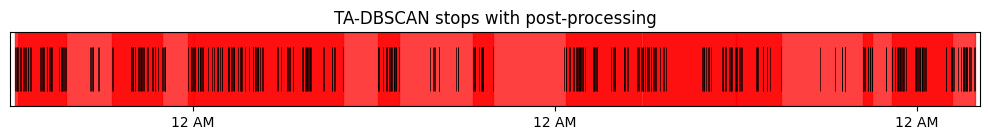

In [20]:
fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_tadb, ax=ax_barcode, stop_color='red', set_xlim=False, timestamp='unix_ts')
plt.title("TA-DBSCAN stops with post-processing")
plt.tight_layout()
plt.show()